This notebook is an optimized version of: https://www.kaggle.com/code/jojothepizza/genre-classification-with-fma-data

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, \
ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
import os
import zipfile
plt.rcParams['figure.figsize'] = (10, 3)

## Data Prep

In [2]:
def rename_fma_features(features):
    df_features_name = features.iloc[:2,1:]
    new_feature_name = ['track_id']
    for i in range(len(df_features_name.columns)):
        feat = df_features_name.iloc[:,i]
        feat_name = feat.name.split('.')[0]
        stat = feat[0]
        num = feat[1]
        name = feat_name+'_'+num+'_'+stat
        new_feature_name.append(name)
    return_df = features.iloc[3:,:].reset_index(drop=True)
    return_df.columns = new_feature_name
    return return_df

In [3]:
# unzip echonest file
file_names = ["features", "tracks", "genres"]

for file_name in file_names:
    zip_path = f"../fma-metadata/{file_name}.zip"
    extract_path = "../fma-metadata/"

    if not os.path.exists(extract_path+file_name+".*"):
        # Open the zip file
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            # Extract all contents to the specified path
            zip_ref.extractall(extract_path)

In [4]:
raw_features = pd.read_csv('../fma-metadata/features.csv', low_memory=False)
features = rename_fma_features(raw_features)

In [5]:
features = features.apply(pd.to_numeric)

In [6]:
features

,track_id,chroma_cens_01_kurtosis,chroma_cens_02_kurtosis,chroma_cens_03_kurtosis,chroma_cens_04_kurtosis,chroma_cens_05_kurtosis,chroma_cens_06_kurtosis,chroma_cens_07_kurtosis,chroma_cens_08_kurtosis,chroma_cens_09_kurtosis,...,tonnetz_04_std,tonnetz_05_std,tonnetz_06_std,zcr_01_kurtosis,zcr_01_max,zcr_01_mean,zcr_01_median,zcr_01_min,zcr_01_skew,zcr_01_std
0,2,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,...,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448
1,3,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,0.108103,...,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330
2,5,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,...,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861
3,10,3.702245,-0.291193,2.196742,-0.234449,1.367364,0.998411,1.770694,1.604566,0.521217,...,0.074358,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800
4,20,-0.193837,-0.198527,0.201546,0.258556,0.775204,0.084794,-0.289294,-0.816410,0.043851,...,0.095003,0.022492,0.021355,16.669037,0.469727,0.047225,0.040039,0.000977,3.189831,0.030993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106569,155316,-0.490129,0.463834,2.321970,-0.084352,1.662914,2.115189,-0.237794,5.695442,0.830353,...,0.128410,0.022547,0.019816,4.448255,0.172852,0.028773,0.028320,0.003906,0.955388,0.012385
106570,155317,-0.461559,-0.229601,-0.496632,-0.422033,0.130612,-0.263825,-0.628103,-0.082687,-0.229483,...,0.132964,0.023548,0.026527,3.270612,0.196289,0.031116,0.027832,0.002441,1.283060,0.019059
106571,155318,0.552473,-0.110498,-0.532014,0.263131,-0.224011,-0.530972,1.713526,1.418444,1.325197,...,0.108324,0.017540,0.020471,2.356727,0.212891,0.038450,0.037109,0.003418,0.828569,0.017904
106572,155319,-0.176901,0.187208,-0.050664,0.368843,0.066005,-0.857354,-0.780860,0.626281,-0.630938,...,0.088311,0.018328,0.017936,6.188604,0.167480,0.041480,0.038086,0.004883,1.818740,0.020133


In [7]:
tracks = pd.read_csv('../fma-metadata/tracks.csv',index_col = 0, low_memory=False)

In [8]:
# ONLY genre_top, genre as Labels
track_info = tracks[["track.7",'track.8']]
track_info.columns = track_info.iloc[0].rename('track_id')
track_info = track_info.iloc[2:]

In [9]:
track_info

track_id,genre_top,genres
2,Hip-Hop,[21]
3,Hip-Hop,[21]
5,Hip-Hop,[21]
10,Pop,[10]
20,NaN,"[76, 103]"
...,...,...
155316,Rock,[25]
155317,Rock,[25]
155318,Rock,[25]
155319,Rock,[25]


In [10]:
track_info.loc[pd.isnull(track_info).any(axis=1)]

track_id,genre_top,genres
20,NaN,"[76, 103]"
26,NaN,"[76, 103]"
30,NaN,"[76, 103]"
46,NaN,"[76, 103]"
48,NaN,"[76, 103]"
...,...,...
155276,NaN,"[15, 32, 38]"
155277,NaN,"[15, 32, 38]"
155278,NaN,"[42, 107]"
155288,NaN,[]


In [11]:
track_info.genre_top.value_counts()

genre_top
Rock                   14182
Experimental           10608
Electronic              9372
Hip-Hop                 3552
Folk                    2803
Pop                     2332
Instrumental            2079
International           1389
Classical               1230
Jazz                     571
Old-Time / Historic      554
Spoken                   423
Country                  194
Soul-RnB                 175
Blues                    110
Easy Listening            24
Name: count, dtype: int64

In [12]:
track_info.genre_top.value_counts().sum()

49598

In [13]:
# put parent genre of the first genre in 'genres' to non-specified 'genre_top'

track_info_wo_genre = track_info.loc[pd.isnull(track_info).any(axis=1)]
genres_df = pd.read_csv('../fma-metadata/genres.csv', low_memory=False)
genre_names = []
for i in track_info_wo_genre.genres:
    j = eval(i)+[0]
    if j[0] != 0:
        top_level = genres_df[genres_df.genre_id==j[0]].top_level.values[0]
        parent_genre = genres_df[genres_df.genre_id==top_level]['title'].values[0]
    else:
        parent_genre = np.nan
    genre_names.append(parent_genre)
track_info_ = track_info.copy()
track_info_.loc[track_info_wo_genre.index, 'genre_top'] = genre_names

In [14]:
track_info_.loc[pd.isnull(track_info_).any(axis=1)]

track_id,genre_top,genres
613,NaN,[]
1213,NaN,[]
1216,NaN,[]
1217,NaN,[]
3276,NaN,[]
...,...,...
155192,NaN,[]
155193,NaN,[]
155194,NaN,[]
155195,NaN,[]


In [15]:
track_info_.genre_top.value_counts()

genre_top
Electronic             25046
Experimental           22724
Rock                   21282
Pop                     8015
Folk                    6083
Hip-Hop                 4534
Instrumental            4367
International           2924
Jazz                    2293
Classical               2102
Blues                   1676
Soul-RnB                 920
Spoken                   768
Country                  726
Old-Time / Historic      710
Easy Listening           173
Name: count, dtype: int64

In [16]:
track_info_.genre_top.value_counts().sum()

104343

In [17]:
track_info_.index = pd.to_numeric(track_info_.index)
genres = track_info_[['genre_top']]
data = pd.concat([genres, features.set_index('track_id')], axis=1).dropna()

In [18]:
data

,genre_top,chroma_cens_01_kurtosis,chroma_cens_02_kurtosis,chroma_cens_03_kurtosis,chroma_cens_04_kurtosis,chroma_cens_05_kurtosis,chroma_cens_06_kurtosis,chroma_cens_07_kurtosis,chroma_cens_08_kurtosis,chroma_cens_09_kurtosis,...,tonnetz_04_std,tonnetz_05_std,tonnetz_06_std,zcr_01_kurtosis,zcr_01_max,zcr_01_mean,zcr_01_median,zcr_01_min,zcr_01_skew,zcr_01_std
2,Hip-Hop,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,...,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448
3,Hip-Hop,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,0.108103,...,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330
5,Hip-Hop,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,...,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861
10,Pop,3.702245,-0.291193,2.196742,-0.234449,1.367364,0.998411,1.770694,1.604566,0.521217,...,0.074358,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800
20,Pop,-0.193837,-0.198527,0.201546,0.258556,0.775204,0.084794,-0.289294,-0.816410,0.043851,...,0.095003,0.022492,0.021355,16.669037,0.469727,0.047225,0.040039,0.000977,3.189831,0.030993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155316,Rock,-0.490129,0.463834,2.321970,-0.084352,1.662914,2.115189,-0.237794,5.695442,0.830353,...,0.128410,0.022547,0.019816,4.448255,0.172852,0.028773,0.028320,0.003906,0.955388,0.012385
155317,Rock,-0.461559,-0.229601,-0.496632,-0.422033,0.130612,-0.263825,-0.628103,-0.082687,-0.229483,...,0.132964,0.023548,0.026527,3.270612,0.196289,0.031116,0.027832,0.002441,1.283060,0.019059
155318,Rock,0.552473,-0.110498,-0.532014,0.263131,-0.224011,-0.530972,1.713526,1.418444,1.325197,...,0.108324,0.017540,0.020471,2.356727,0.212891,0.038450,0.037109,0.003418,0.828569,0.017904
155319,Rock,-0.176901,0.187208,-0.050664,0.368843,0.066005,-0.857354,-0.780860,0.626281,-0.630938,...,0.088311,0.018328,0.017936,6.188604,0.167480,0.041480,0.038086,0.004883,1.818740,0.020133


In [19]:
data.to_csv('data_FMA_genre_clf_prepped.csv')

## Feature Engineering

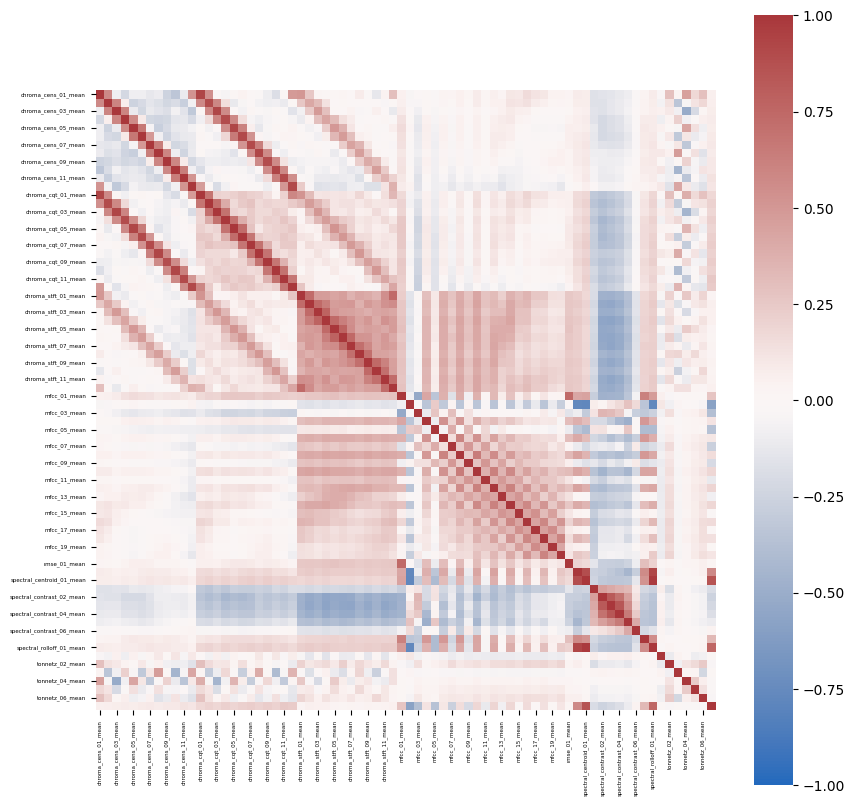

In [20]:
df_ft_mean = data[[col for col in data.columns if 'mean' in col]]

plt.figure(figsize=(10,10))
sns.heatmap(df_ft_mean.corr(), cmap='vlag', vmin=-1, vmax=1,center=0, square=True)
plt.xticks(fontsize = 4)
plt.yticks(fontsize = 4)
plt.show()

In [21]:
columns_cens = [col for col in data.columns if 'cens' in col]
columns_cstft = [col for col in data.columns if 'stft' in col]
columns_sband = [col for col in data.columns if 'bandwidth' in col]
columns_srolloff = [col for col in data.columns if 'rolloff' in col]

In [22]:
data_ = data.drop(columns=columns_cens+columns_cstft+columns_sband+columns_srolloff)

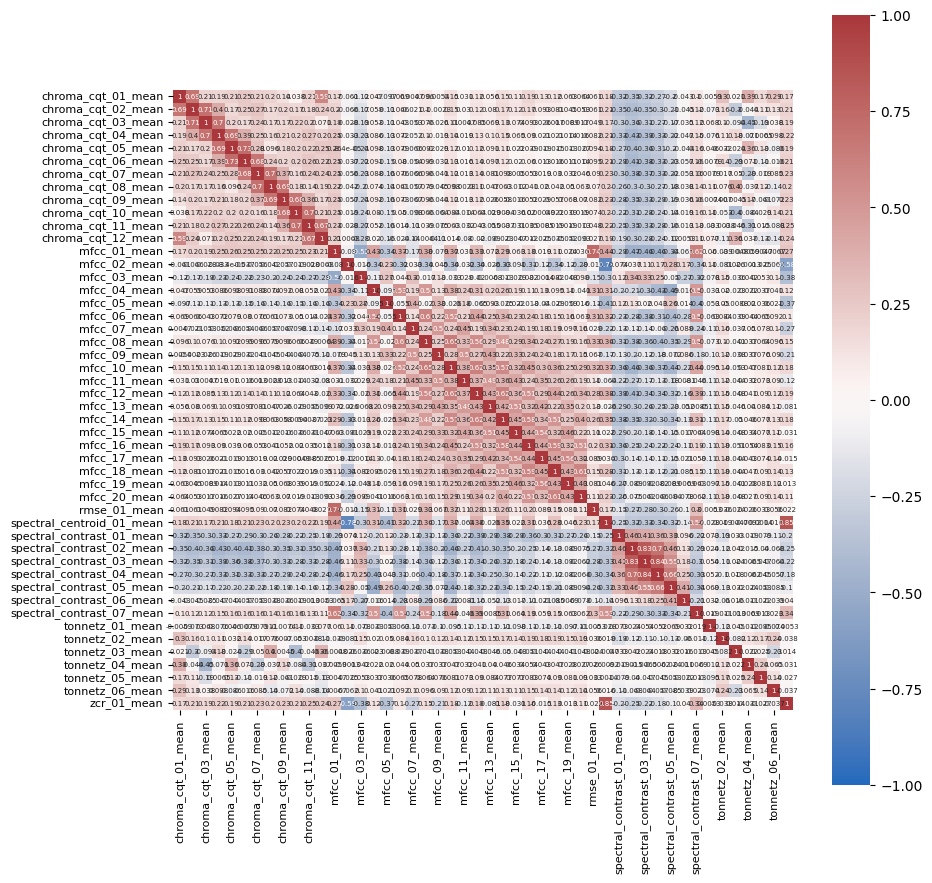

In [23]:
df_ft_mean = data_[[col for col in data_.columns if 'mean' in col]]
plt.figure(figsize=(10,10))
sns.heatmap(df_ft_mean.corr(), cmap='vlag', vmin=-1, vmax=1,center=0, square=True, annot=True, annot_kws={'fontsize':5})
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.show()

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FactorAnalysis

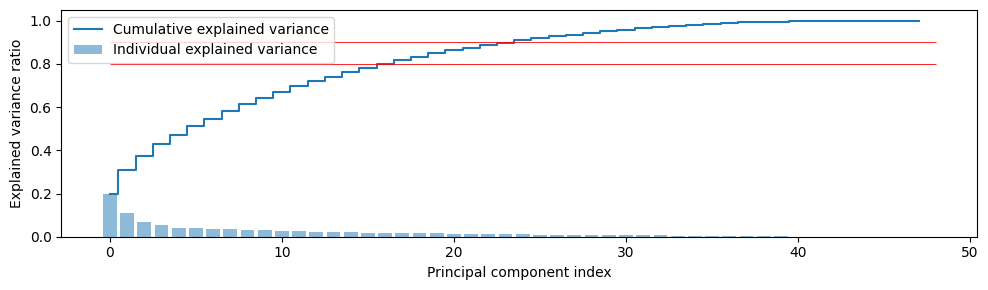

In [25]:
sc = StandardScaler()
df_ft_mean_scaled = sc.fit_transform(df_ft_mean)

pca = PCA()
ft_pca = pca.fit_transform(df_ft_mean_scaled)

exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.hlines(0.8, xmin=0, xmax=len(cum_sum_eigenvalues), color='red', linewidth=.6)
plt.hlines(0.9, xmin=0, xmax=len(cum_sum_eigenvalues), color='red', linewidth=.6)
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

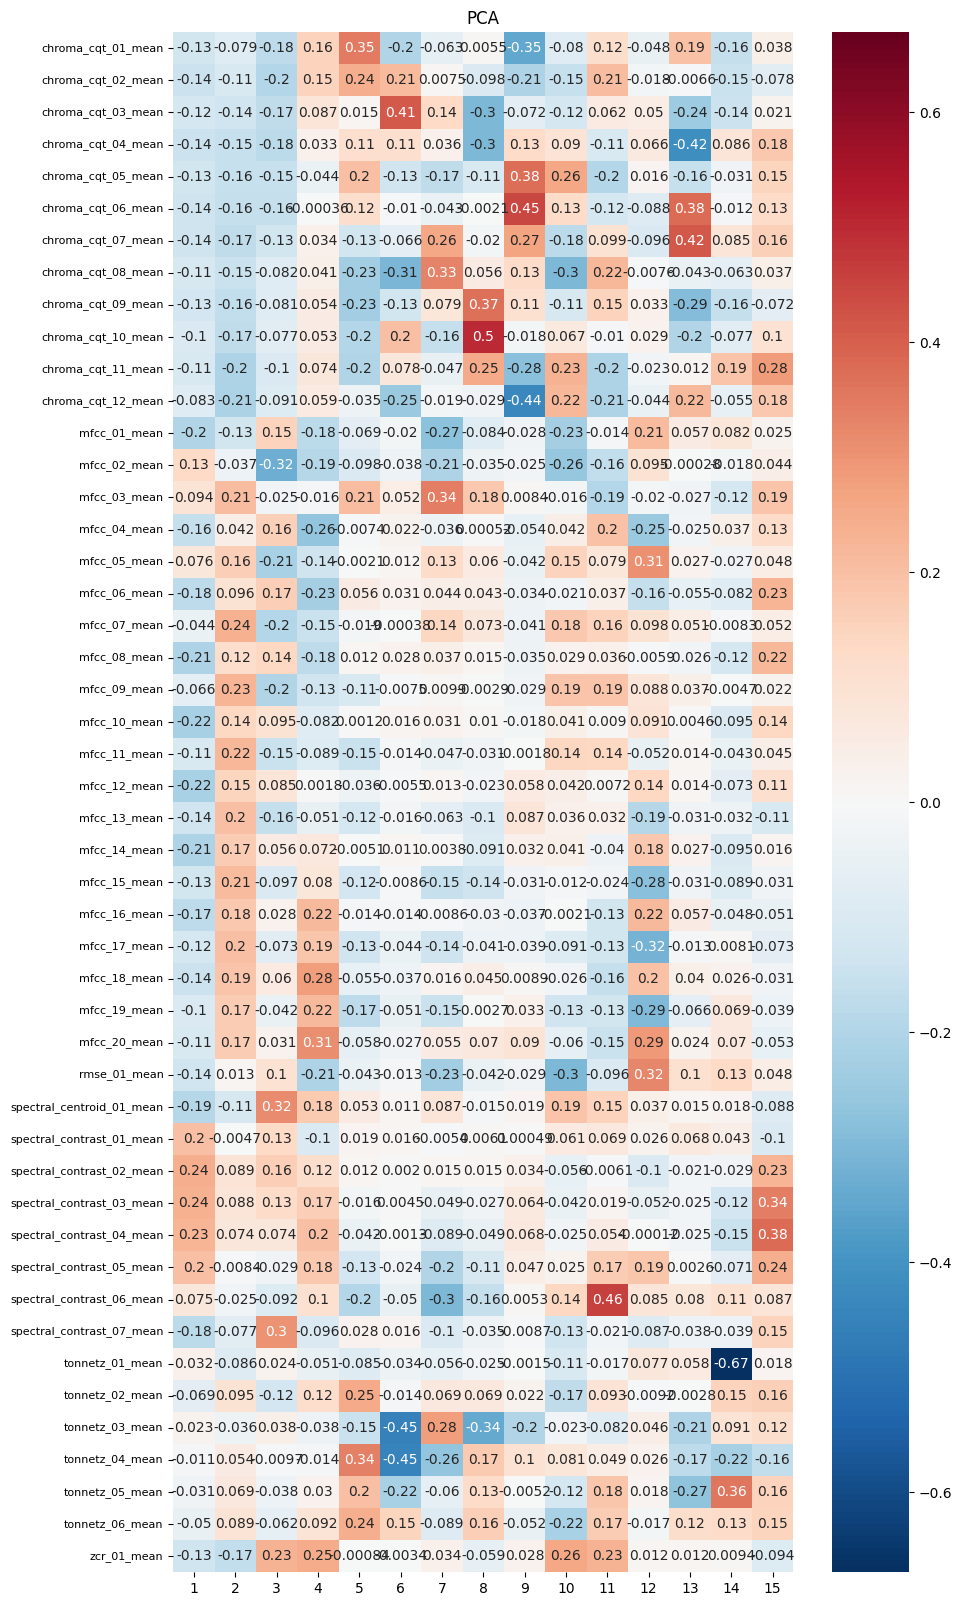

In [26]:
n_comps = 15 # 0.8 explained variance for pca
feature_names = df_ft_mean.columns

methods = [
    ("PCA", PCA())]

for (method, fa) in methods:
    fig, ax = plt.subplots(figsize=(10,20))
    fa.set_params(n_components=n_comps)
    fa.fit(df_ft_mean_scaled)

    components = fa.components_.T

    vmax = np.abs(components).max()
    sns.heatmap(components, cmap="RdBu_r", vmax=vmax, vmin=-vmax, ax=ax, annot=True)
    ax.set_yticklabels(labels=feature_names, rotation=0, fontdict={'fontsize':8})
    ax.set_xticklabels(labels= range(1, n_comps+1))
    ax.set_title(str(method))
    plt.show()

In [27]:
top_genres = data_.genre_top.value_counts()
top_genres

genre_top
Electronic             25046
Experimental           22724
Rock                   21282
Pop                     8015
Folk                    6083
Hip-Hop                 4534
Instrumental            4367
International           2924
Jazz                    2293
Classical               2102
Blues                   1676
Soul-RnB                 920
Spoken                   768
Country                  726
Old-Time / Historic      710
Easy Listening           173
Name: count, dtype: int64

In [28]:
international_ids = data_[data_['genre_top']=='International'].index
data_ = data_.drop(index=international_ids)

In [29]:
small_genres = top_genres[top_genres<1000].index
for x in small_genres:
    ids = data_[data_['genre_top']==x].index
    data_ = data_.drop(index=ids)

In [30]:
len(data_)

98122

In [31]:
raw_X = data_.drop(columns=['genre_top'])

labels = data_.loc[:,'genre_top']
cat_y = pd.Categorical(labels)
y = pd.Series(cat_y.codes)

# train / test
raw_X_train, raw_X_test, y_train, y_test = train_test_split(raw_X, y, test_size=0.3, shuffle=True, random_state=123)

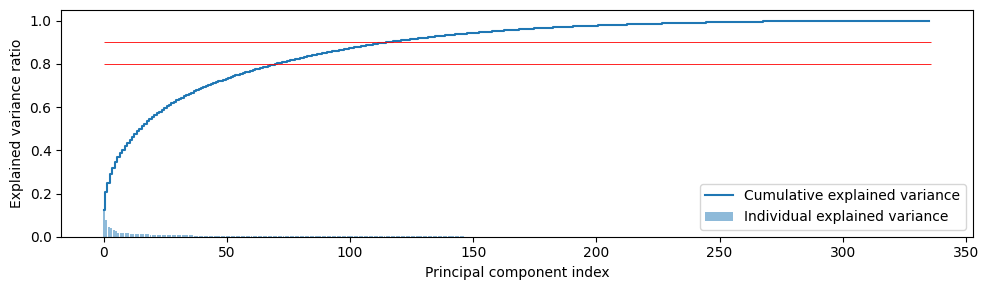

In [32]:
sc = StandardScaler()
raw_X_scaled_train = sc.fit_transform(raw_X_train)
raw_X_scaled_test = sc.transform(raw_X_test)

pca = PCA()
ft_pca = pca.fit_transform(raw_X_scaled_train)

exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.hlines(0.8, xmin=0, xmax=len(cum_sum_eigenvalues), color='red', linewidth=.6)
plt.hlines(0.9, xmin=0, xmax=len(cum_sum_eigenvalues), color='red', linewidth=.6)
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [33]:
n_comps = 60 # 0.8 explained variance for pca
pca = PCA(n_components=n_comps)
X_train = pca.fit_transform(raw_X_scaled_train)
X_train = pd.DataFrame(X_train, index=raw_X_train.index, columns=[f'PCA_{n}' for n in range(1,n_comps+1)])
X_test = pca.transform(raw_X_scaled_test)
X_test = pd.DataFrame(X_test, index=raw_X_test.index, columns=[f'PCA_{n}' for n in range(1,n_comps+1)])

In [34]:
y_train.value_counts()

2    17612
3    15947
9    14857
8     5574
4     4245
5     3198
6     3016
7     1592
1     1460
0     1184
Name: count, dtype: int64

In [35]:
y_train.value_counts()

2    17612
3    15947
9    14857
8     5574
4     4245
5     3198
6     3016
7     1592
1     1460
0     1184
Name: count, dtype: int64

Modelling

In [36]:
classifier = XGBClassifier()

params = {
 "learning_rate" : [0.05,0.10,0.15,0.20,0.25,0.30],
 "max_depth" : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight": [ 1, 3, 5, 7 ],
 "gamma" : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
 "booster" : ["dart", "gbtree"],
 "sub_sample" : [0.5, 0.6, 0.7, 0.8, 0.9, 1],
}

In [37]:
rs_model=RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,scoring='accuracy',n_jobs=-1,cv=5,verbose=3)

In [38]:
#model fitting
rs_model.fit(X_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[18:43:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "sub_sample" } are not used.



RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'booster': ['dart', 'gbtree'],
                                        'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7],
                                        'sub_sample': [0.5, 0.6, 0.7, 0.8, 0.9,
                                                       1]},
                   scoring='accuracy', verbose=3)

In [39]:
#parameters selected
rs_model.best_estimator_

XGBClassifier(base_score=None, booster='dart', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.4, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [47]:

xgb = rs_model.best_estimator_

In [48]:
xgb.fit(X_train, y_train)

[19:35:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "sub_sample" } are not used.



XGBClassifier(base_score=None, booster='dart', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.4, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [49]:
y_true = y_test.copy()
y_pred = xgb.predict(X_test)

In [50]:
print('XGB Accuracy: ', accuracy_score(y_true, y_pred))
print('XGB F1: ', f1_score(y_true, y_pred, average='macro'))

XGB Accuracy:  0.5201617012603187
XGB F1:  0.39696489556325104


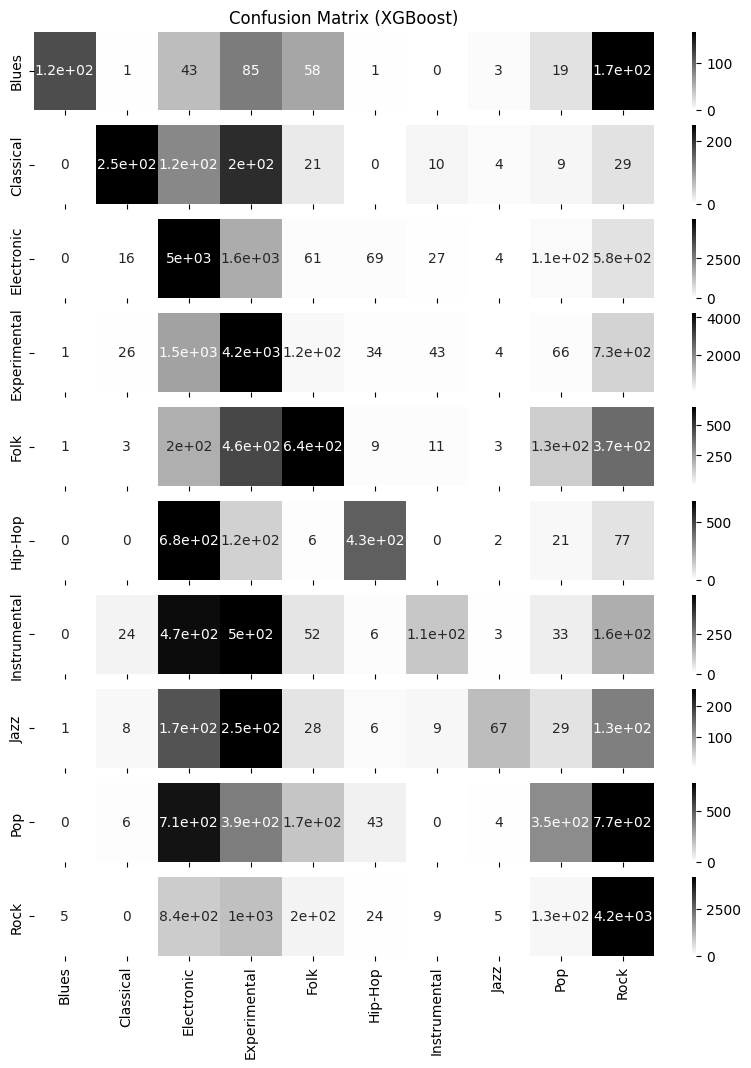

In [51]:
fig, axs = plt.subplots(10, figsize=(10,12), sharex=True)
axs[0].set_title('Confusion Matrix (XGBoost)')
axs[9].set_xlabel('Predicted labels')

for i in range(10):    
    sns.heatmap(confusion_matrix(y_true, y_pred)[i].reshape(1,-1), annot=True, cmap='gray_r',
                xticklabels=cat_y.categories, yticklabels=[cat_y.categories[i]], ax=axs[i])
plt.show()

In [52]:
print("XGB classification report:",'\n')
print(classification_report(y_true, y_pred))
print(dict(zip(cat_y.categories, range(10))))

XGB classification report: 

              precision    recall  f1-score   support

           0       0.94      0.24      0.38       492
           1       0.75      0.39      0.51       642
           2       0.51      0.67      0.58      7434
           3       0.47      0.62      0.54      6777
           4       0.47      0.35      0.40      1838
           5       0.69      0.32      0.44      1336
           6       0.50      0.08      0.14      1351
           7       0.68      0.10      0.17       701
           8       0.39      0.14      0.21      2441
           9       0.58      0.65      0.61      6425

    accuracy                           0.52     29437
   macro avg       0.60      0.35      0.40     29437
weighted avg       0.53      0.52      0.49     29437

{'Blues': 0, 'Classical': 1, 'Electronic': 2, 'Experimental': 3, 'Folk': 4, 'Hip-Hop': 5, 'Instrumental': 6, 'Jazz': 7, 'Pop': 8, 'Rock': 9}


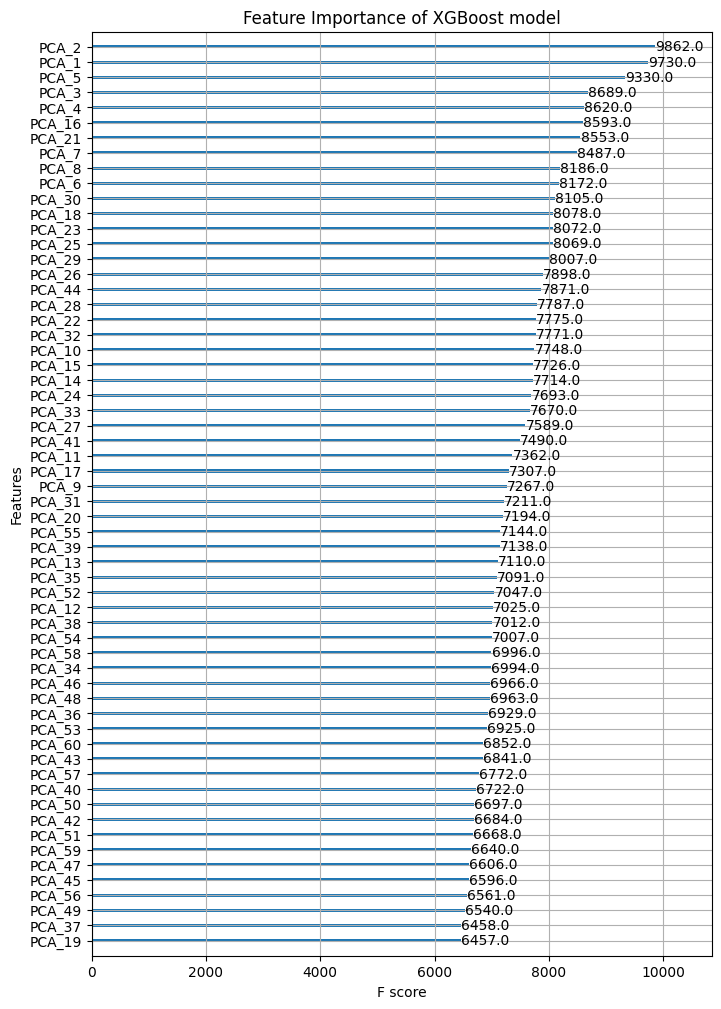

In [53]:
fig, ax = plt.subplots(figsize=(8,12))
from xgboost import plot_importance
plot_importance(xgb, ax=ax, title='Feature Importance of XGBoost model')
plt.show()